# **Train with cycleGAN Generated Image**

class: AD/CN (2)

data: cycleGAN generated image

data_path: /content/drive/MyDrive/Classfication 내에 두 가지 레이블 폴더로 구분

input_size: (224,224,3)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report,accuracy_score
from IPython.display import Markdown, display

In [3]:
dir_ = Path('/content/drive/MyDrive/Classification/generated')
filepaths = list(dir_.glob(r'**/*.png'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Classification/generate...,CN
1,/content/drive/MyDrive/Classification/generate...,AD
2,/content/drive/MyDrive/Classification/generate...,CN
3,/content/drive/MyDrive/Classification/generate...,CN
4,/content/drive/MyDrive/Classification/generate...,CN


In [4]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 180

Number of different labels: 2

Labels: ['CN' 'AD']


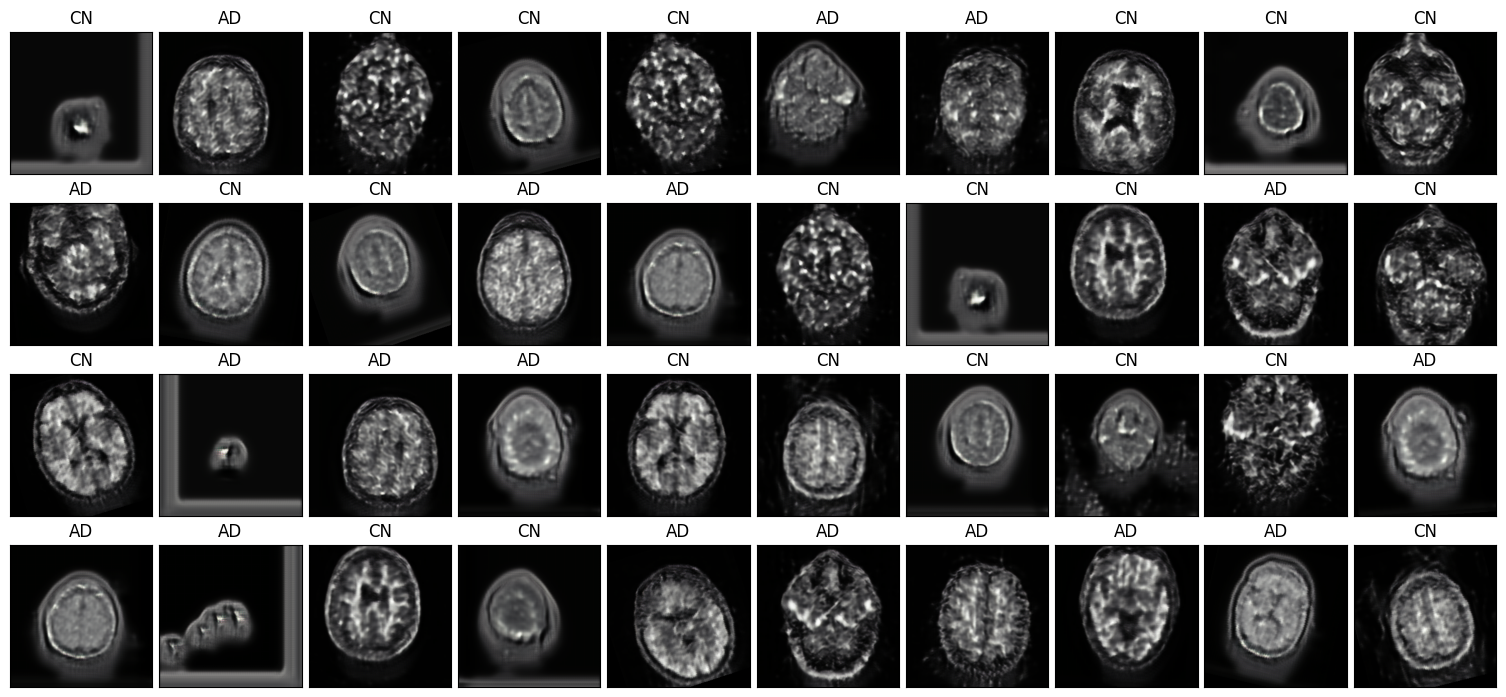

In [5]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

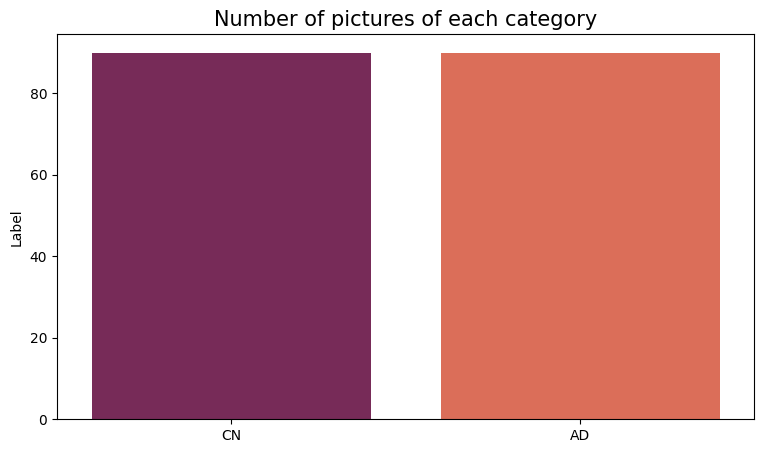

In [6]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [26]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((144, 2), (36, 2))

In [27]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [28]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretrained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 2개이기 때문에 Dence도 2로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=3,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 130 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


DenseNet121          trained in 61.53 sec
MobileNetV2          trained in 17.57 sec
DenseNet201          trained in 116.44 sec
EfficientNetB0       trained in 33.63 sec
EfficientNetB1       trained in 48.18 sec
InceptionV3          trained in 54.58 sec
MobileNetV3Large     trained in 14.75 sec
ResNet152V2          trained in 140.61 sec
ResNet50             trained in 64.35 sec
ResNet50V2           trained in 54.38 sec
VGG19                trained in 227.71 sec
VGG16                trained in 224.92 sec
Xception             trained in 84.18 sec


In [29]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)

    # Convert labels to binary format (0 or 1)
    y_test_bin = [1 if label == 'AD' else 0 for label in y_test]
    pred_bin = [1 if label == 'AD' else 0 for label in pred]

    acc = accuracy_score(y_test,pred)
    f1 = f1_score(y_test_bin, pred_bin)
    models[name]['acc'] = round(acc,4)
    models[name]['f1'] = round(f1, 4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['f1'],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','f1 score','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

2/2 [==============================] - 5s 334ms/step
**DenseNet121 has a 72.22% accuracy on the test set**
2/2 [==============================] - 1s 65ms/step
**MobileNetV2 has a 75.00% accuracy on the test set**
2/2 [==============================] - 9s 533ms/step
**DenseNet201 has a 63.89% accuracy on the test set**
2/2 [==============================] - 3s 128ms/step
**EfficientNetB0 has a 50.00% accuracy on the test set**
2/2 [==============================] - 4s 183ms/step
**EfficientNetB1 has a 61.11% accuracy on the test set**
2/2 [==============================] - 5s 404ms/step
**InceptionV3 has a 55.56% accuracy on the test set**
2/2 [==============================] - 2s 69ms/step
**MobileNetV3Large has a 52.78% accuracy on the test set**
2/2 [==============================] - 12s 1s/step
**ResNet152V2 has a 75.00% accuracy on the test set**
2/2 [==============================] - 6s 415ms/step
**ResNet50 has a 66.67% accuracy on the test set**
2/2 [============================

,model,f1 score,accuracy,Training time (sec)
0,MobileNetV2,0.7568,0.7500,17.57
1,ResNet152V2,0.7805,0.7500,140.61
2,ResNet50V2,0.7568,0.7500,54.38
3,DenseNet121,0.7619,0.7222,61.53
4,VGG16,0.7660,0.6944,224.92
5,ResNet50,0.7391,0.6667,64.35
6,DenseNet201,0.7234,0.6389,116.44
7,Xception,0.7234,0.6389,84.18
8,EfficientNetB1,0.7083,0.6111,48.18
9,VGG19,0.5714,0.5833,227.71


from matplotlib import pyplot as plt
_df_18['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['f1 score'].plot(kind='hist', bins=20, title='f1 score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['Training time (sec)'].plot(kind='hist', bins=20, title='Training time (sec)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='index', y='f1 score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='f1 score', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='accuracy', y='Training time (sec)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['f1 score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('f1 score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Training time (sec)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Training time (sec)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_29['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['f1 score'].plot(kind='line', figsize=(8, 4), title='f1 score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_32['Training time (sec)'].plot(kind='line', figsize=(8, 4), title='Training time (sec)')
plt.gca().spines[['top', 'right']].set_visible(False)

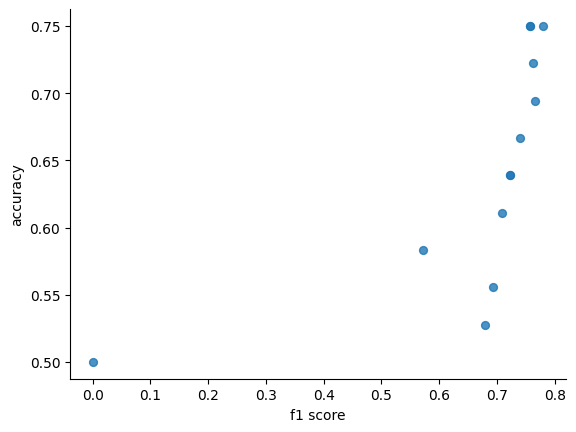

In [31]:
from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='f1 score', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

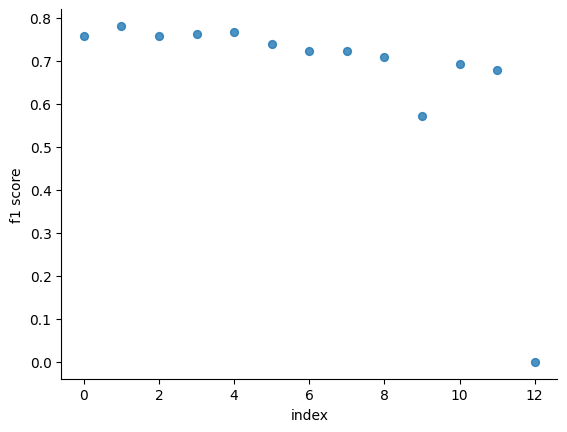

In [30]:
from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='index', y='f1 score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Train with Original MRI/PET Image**

class: AD/CN (2)

data: cycleGAN generated image

data_path: /content/drive/MyDrive/classfication 내에 두 가지 레이블 폴더로 구분

input_size: (224,224,3)

In [9]:
dir_original = Path('/content/drive/MyDrive/Classification/original')
original_filepaths = list(dir_original.glob(r'**/*.png'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(original_filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Classification/original...,AD
1,/content/drive/MyDrive/Classification/original...,CN
2,/content/drive/MyDrive/Classification/original...,AD
3,/content/drive/MyDrive/Classification/original...,AD
4,/content/drive/MyDrive/Classification/original...,AD


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Filepath').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Label'].value_counts()
    for x_label, grp in _df_2.groupby('Filepath')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Filepath')
_ = plt.ylabel('Label')

In [10]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
original_train_df,original_test_df = train_test_split(df, test_size=0.2,random_state=0)
original_train_df.shape,original_test_df.shape

((144, 2), (36, 2))

In [15]:
def create_original_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=original_train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=original_train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=original_test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [12]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
original_train_generator,original_test_generator,original_train_images,original_val_images,original_test_images=create_original_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 2개이기 때문에 Dencs도 2로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(original_train_images,validation_data=original_val_images,epochs=3,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 130 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


29084464/29084464 [==============================] - 0s 0us/step
DenseNet121          trained in 70.51 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 14.18 sec
74836368/74836368 [==============================] - 0s 0us/step
DenseNet201          trained in 131.45 sec
16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 36.62 sec
27018416/27018416 [==============================] - 0s 0us/step


EfficientNetB1       trained in 38.34 sec
87910968/87910968 [==============================] - 0s 0us/step


InceptionV3          trained in 47.73 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 12.45 sec
234545216/234545216 [==============================] - 1s 0us/step
ResNet152V2          trained in 173.77 sec
94765736/94765736 [==============================] - 0s 0us/step
ResNet50             trained in 62.62 sec
94668760/94668760 [==============================] - 0s 0us/step
ResNet50V2           trained in 60.94 sec
80134624/80134624 [==============================] - 0s 0us/step
VGG19                trained in 224.08 sec
58889256/58889256 [==============================] - 0s 0us/step
VGG16                trained in 194.37 sec
83683744/83683744 [==============================] - 0s 0us/step
Xception             trained in 85.17 sec


In [20]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(original_test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (original_train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(original_test_df.Label)

    # Convert labels to binary format (0 or 1)
    y_test_bin = [1 if label == 'AD' else 0 for label in y_test]
    pred_bin = [1 if label == 'AD' else 0 for label in pred]

    acc = accuracy_score(y_test,pred)
    f1 = f1_score(y_test_bin, pred_bin)
    models[name]['acc'] = round(acc,4)
    models[name]['f1'] = round(f1, 4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['f1'],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','f1 score','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

2/2 [==============================] - 3s 317ms/step
**DenseNet121 has a 63.89% accuracy on the test set**
2/2 [==============================] - 1s 66ms/step
**MobileNetV2 has a 72.22% accuracy on the test set**
2/2 [==============================] - 9s 505ms/step
**DenseNet201 has a 72.22% accuracy on the test set**
2/2 [==============================] - 2s 125ms/step
**EfficientNetB0 has a 50.00% accuracy on the test set**
2/2 [==============================] - 5s 180ms/step
**EfficientNetB1 has a 50.00% accuracy on the test set**


2/2 [==============================] - 3s 274ms/step
**InceptionV3 has a 50.00% accuracy on the test set**


2/2 [==============================] - 1s 67ms/step
**MobileNetV3Large has a 61.11% accuracy on the test set**
2/2 [==============================] - 13s 1s/step
**ResNet152V2 has a 69.44% accuracy on the test set**
2/2 [==============================] - 6s 547ms/step
**ResNet50 has a 66.67% accuracy on the test set**
2/2 [==============================] - 4s 361ms/step
**ResNet50V2 has a 69.44% accuracy on the test set**
2/2 [==============================] - 19s 2s/step
**VGG19 has a 55.56% accuracy on the test set**
2/2 [==============================] - 14s 2s/step
**VGG16 has a 58.33% accuracy on the test set**
2/2 [==============================] - 6s 481ms/step
**Xception has a 58.33% accuracy on the test set**


,model,f1 score,accuracy,Training time (sec)
0,MobileNetV2,0.7826,0.7222,14.18
1,DenseNet201,0.6667,0.7222,131.45
2,ResNet152V2,0.7179,0.6944,173.77
3,ResNet50V2,0.7179,0.6944,60.94
4,ResNet50,0.7391,0.6667,62.62
5,DenseNet121,0.6977,0.6389,70.51
6,MobileNetV3Large,0.7083,0.6111,12.45
7,VGG16,0.7059,0.5833,194.37
8,Xception,0.6809,0.5833,85.17
9,VGG19,0.5789,0.5556,224.08


from matplotlib import pyplot as plt
_df_3['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['f1 score'].plot(kind='hist', bins=20, title='f1 score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Training time (sec)'].plot(kind='hist', bins=20, title='Training time (sec)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='index', y='f1 score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='f1 score', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='accuracy', y='Training time (sec)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['f1 score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('f1 score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Training time (sec)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Training time (sec)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_14['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['f1 score'].plot(kind='line', figsize=(8, 4), title='f1 score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Training time (sec)'].plot(kind='line', figsize=(8, 4), title='Training time (sec)')
plt.gca().spines[['top', 'right']].set_visible(False)

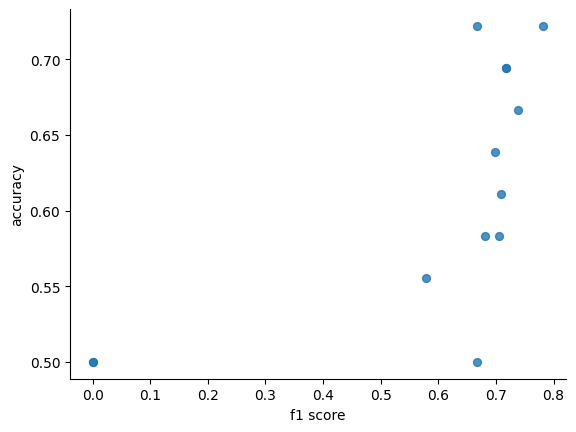

In [33]:
from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='f1 score', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

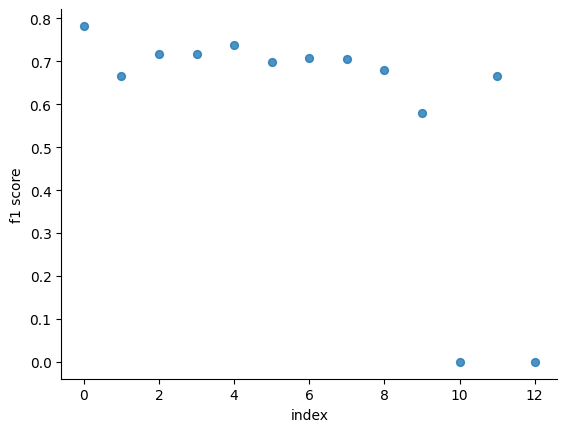

In [22]:
from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='index', y='f1 score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)